# Plot Utilization for Streaming Tasks
Demonstrate that the simulation tasks are working as intended

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
run_path = Path('runs/stream-120324-093329/')

## Load in Generation and Simulation Results
They are stored in JSON files that contain the inputs, outputs, and tracking information

In [3]:
with open(run_path / 'generation-tasks.json') as fp:
    gen_data = pd.json_normalize([json.loads(l) for l in fp], sep='_')

In [4]:
with open(run_path / 'simulation-tasks.json') as fp:
    sim_data = pd.json_normalize([json.loads(l) for l in fp], sep='_')

Compute the time since the workflow start

In [5]:
start_time = gen_data['timestamp_created'].min()

In [6]:
for data in [gen_data, sim_data]:
    data['walltime'] = data['timestamp_result_received'] - start_time

## Evaluate Performance
See if we are getting better over time

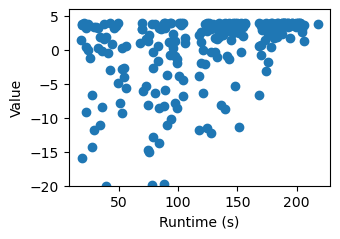

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(sim_data['walltime'], sim_data['value'])

ax.set_ylim(-20, 6)
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Value')
fig.tight_layout()

The distribution of outputs gets larger over time as the generator trains to better mimic high-performing entries.

Show the drift of the mean and std of the generator

In [8]:
gen_complete = gen_data.query('complete').copy()

In [9]:
gen_complete['mean'], gen_complete['std'] = zip(*gen_complete['value'])

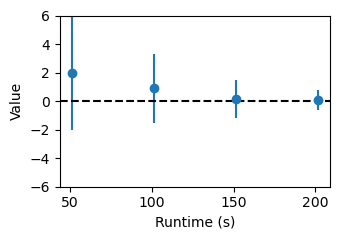

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.errorbar(gen_complete['walltime'], gen_complete['mean'], fmt='o', yerr=gen_complete['std'])

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0, 0], 'k--')

ax.set_ylim(-6, 6)
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Value')
fig.tight_layout()

fig.savefig('figures/generator-training.png', dpi=320)

The generator converges on a mean centered about the actual maximum

## Plot Assignment to Different "Nodes"
See how work is distributed

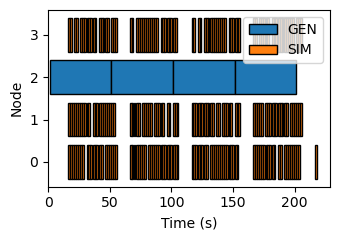

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for label, data in zip(['GEN', 'SIM'], [gen_complete, sim_data]):
    data["worker"] = data['worker_info_PARSL_WORKER_RANK'].apply(int)
    ax.barh(y=data["worker"], width=data["time_running"], left=data["timestamp_compute_started"] - start_time, label=label, edgecolor='k')
    
ax.set_yticks(np.arange(data["worker"].max() + 1))
ax.set_ylabel('Node')

ax.set_xlim([0, max(ax.get_xlim())])

ax.set_xlabel('Time (s)')
ax.legend()
fig.tight_layout()
fig.savefig('figures/allocation.png', dpi=320)

Note the first simulation tasks starting before the generator finishes training. That is the streaming implementation at work.